In [7]:
# python3
# coding: utf-8

"""
CS7641 - Assignment 3 Multilayer Perception Analysis

Mike Tong


Created: MAR 2019
"""

import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.feature_selection import SelectKBest, GenericUnivariateSelect, mutual_info_classif
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI, mutual_info_score as MI
from sklearn.random_projection import GaussianRandomProjection as GRP


from ancillary import measure_execution_time, prep_data_for_clf, plot_learning_curve

In [18]:
class MLPC_Analysis(object):
    def __init__(self, dataset, target, save=False, random_state=7308):
        self.data = dataset
        self.target = target
        self.save = save
        self.random = random_state

    def general_analysis(self):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            print("\n######")
            print("Multilayer Perceptron Classifier:")
            print('Default Baseline values\n')

            clf = MLPClassifier(random_state=self.random, max_iter=1000,)
            plot_learning_curve(clf, '{} MLP Learning Curve'.format(
                self.data.index.name), self.data, self.target, cv=5, scale=True)

            print("\n~~~~~~")
            print("Execution time metrics")
            X_train, X_test, y_train, y_test = prep_data_for_clf(
                self.data, self.target, random_state=self.random)

            sclr = StandardScaler()
            sclr.fit(X_train.astype('float'))
            X_train_std = sclr.transform(X_train.astype('float'))
            X_test_std = sclr.transform(X_test.astype('float'))
            training_time, testing_time = measure_execution_time(clf,
                pd.concat([pd.DataFrame(X_train_std), pd.DataFrame(X_test_std)]), pd.concat([y_train, y_test])
                )
            print("Training time input dim of {} : {:.4f} (+/- {:.4f})".format(
                X_train.shape, np.mean(training_time), np.std(training_time))
                )
            print("Testing time input dim of {}: {:.4f} (+/- {:.4f})".format(
                X_test.shape, np.mean(testing_time), np.std(testing_time))
                )

            print("\n~~~~~~")
            scores = cross_val_score(clf,
                pd.concat([pd.DataFrame(X_train_std), pd.DataFrame(X_test_std)]), pd.concat([y_train, y_test]),
                    cv=10, n_jobs=-1)

            print("10 Fold Cross Validation Accuracy: {:.4f} (+/- {:.4f})".format(
                scores.mean(), scores.std() * 2))

            clf.fit(X_train_std, y_train)
            preds_train = clf.predict(X_train_std)
            preds_test = clf.predict(X_test_std)

            print("Training Accuracy:",
                accuracy_score(y_true=y_train, y_pred=preds_train))
            print("Training F1:",
                f1_score(y_true=y_train, y_pred=preds_train, average='weighted'))
            print("Testing Accuracy:",
                accuracy_score(y_true=y_test, y_pred=preds_test))
            print("Testing F1:",
                f1_score(y_true=y_test, y_pred=preds_test, average='weighted'))
            print('~~~~~~\n')

    def max_iteration_analysis(self, range_=range(100, 1100, 100)):
        print("\n######")
        print("Testing different max iterations.")
        metrics = defaultdict(list)
        X_train, X_test, y_train, y_test = prep_data_for_clf(
            self.data, self.target, random_state = self.random)

        sclr = StandardScaler()
        sclr.fit(X_train.astype('float'))
        X_train_std = sclr.transform(X_train.astype('float'))
        X_test_std = sclr.transform(X_test.astype('float'))

        for r in range_:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                clf = MLPClassifier(random_state=self.random, max_iter=r)
                clf.fit(X_train, y_train)

                preds_train = clf.predict(X_train_std)
                preds_test = clf.predict(X_test_std)

                metrics['train_acc'].append(
                    accuracy_score(y_true=y_train, y_pred=preds_train))
                metrics['test_acc'].append(
                    accuracy_score(y_true=y_test, y_pred=preds_test))

        results = pd.DataFrame(metrics, index=range_)
        results.index.name = "max_iter"

        plt.gcf().set_size_inches(8, 5)
        for col in metrics:
            plt.plot(range_, metrics[col], 'o-')
        plt.legend(['Training', 'Testing'], ncol=1, loc=4)

        plt.xlabel('Max Number of Iterations')
        plt.ylabel('Accuracy Score (weighted)')
        plt.xticks(range_, rotation=45)
        plt.title('MLPC Train and Test Accuracy for {}'.format(
            self.data.index.name))

        plt.grid()
        plt.show()

        self.best_iter= results['test_acc'].idxmax()

        if self.save:
            results.to_csv("./results/MLPC/{}_max_iter_analysis.csv".format(
                self.data.index.name))

        return results

    def hidden_layer_analysis(self, range_ = range(2,11)):
        print("\n######")
        print("Testing Different Node Numbers via Alpha Parameter")
        metrics = defaultdict(list)
        X_train, X_test, y_train, y_test = prep_data_for_clf(
            self.data, self.target, random_state=self.random)

        sclr = StandardScaler()
        sclr.fit(X_train.astype('float'))
        X_train_std = sclr.transform(X_train.astype('float'))
        X_test_std = sclr.transform(X_test.astype('float'))

        num_hidden_layers = []
        for alpha in [10, 11, 13, 15, 17, 21, 26, 34, 52]:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
#                 hidden = self.num_hidden(self.data, 3, alpha)
                hidden = alpha
                num_hidden_layers.append(hidden)

                clf = MLPClassifier(hidden_layer_sizes=(hidden, 2), max_iter=1000,
                early_stopping=True, random_state=self.random)

                clf.fit(X_train_std, y_train)
                preds_train = clf.predict(X_train_std)
                preds_test = clf.predict(X_test_std)

                metrics['train_acc'].append(
                    accuracy_score(y_true=y_train, y_pred=preds_train))
                metrics['test_acc'].append(
                    accuracy_score(y_true=y_test, y_pred=preds_test))

        results = pd.DataFrame(metrics, index=num_hidden_layers)
        results['alpha'] = range_
        results.index.name = "n_hidden"

        self.plot_hl(num_hidden_layers, stats=results,
        	     plt_title='MLPC Train and Test Accuracy for {}'.format(
                    self.data.index.name))
        self.best_n_nodes = results['test_acc'].idxmax()
        if self.save:
            results.to_csv("./results/MLPC/{}_hidden_layer_analysis.csv".format(
            self.data.index.name))

        return results

    def activation_analysis(self):
        print("\n######")
        print("Testing Different Activation Functions with 10 Fold X-Val")
        X_train, X_test, y_train, y_test = prep_data_for_clf(self.data, self.target, random_state=self.random)

        sclr = StandardScaler()
        sclr.fit(X_train.astype('float'))
        X_train_std = sclr.transform(X_train.astype('float'))
        X_test_std = sclr.transform(X_test.astype('float'))

        activations = ['identity', 'logistic', 'tanh', 'relu']
        # n_outputs = self.data[self.target].nunique()
        try:
            hidden = self.best_n_nodes
        except:
            hidden = self.num_hidden(self.data, 3, 4)

        accuracy = []
        stdev = []

        for activation in activations:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                clf = MLPClassifier(activation=activation,
                    hidden_layer_sizes=(hidden, 2), max_iter=1000,
                    early_stopping=True,
                    random_state=self.random)

                scores = cross_val_score(clf,
                    pd.concat([pd.DataFrame(X_train_std), pd.DataFrame(X_test_std)]), pd.concat([y_train, y_test]),
                    cv=10, n_jobs=-1)

                accuracy.append(scores.mean())
                stdev.append(scores.std() * 2)

        results = pd.DataFrame(index=activations,
            data=np.array([accuracy, stdev]).T,
            columns=['acc', 'std'])

        if self.save:
            results.to_csv("./results/MLPC/{}_MLPC_activation_analysis.csv".format(
                self.data.index.name)
                )

        return results

    def num_hidden(self, df, classes, alpha):
        """
        From: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/1097#1097
        """
        return round(df.shape[0]/(alpha * (df.shape[1] + classes)))

    def plot_hl(self, hidden_layers, stats, plt_title):
        plt.gcf().set_size_inches(8, 5)
        for col in stats.drop(columns=['alpha'], axis=1):
            plt.plot(hidden_layers, stats[col], 'o-')
        plt.legend(['Training', 'Testing'], ncol=1, loc=4)

        plt.xlabel('Number of Hidden Units')
        plt.ylabel('Accuracy Score (weighted)')
        plt.xticks(hidden_layers)
        plt.title(plt_title)

        plt.grid()
        plt.show()


In [10]:
df_main = pd.read_csv("./assets/cleaned_student_data.csv")
X_student = df_main.iloc[:, :-1]
y_student = df_main.iloc[:, -1]

df_main = pd.read_csv("./assets/cleaned_housing_data.csv")
X_housing = df_main.iloc[:, :-1].astype('float')
y_housing = df_main.iloc[:, -1]
re_label = dict(zip(y_housing.unique()[::-1], range(y_housing.unique().size)))  # convert 'Group x' to int
y_housing = y_housing.replace(re_label) 

In [11]:
X, y = X_housing.copy(), y_housing
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

transformer = PCA(n_components=19, random_state=7308)
X_pca = transformer.fit_transform(X_std)

transformer = ICA(n_components=20, random_state=7308)
X_ica = transformer.fit_transform(X_std)

transformer = GRP(n_components=17, random_state=7308)
X_grp = transformer.fit_transform(X_std)

transformer = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=5)
X_gup = transformer.fit_transform(X_std, y)

results = []
for xs in [X_pca, X_ica, X_grp, X_gup]:
    dataset = pd.DataFrame(np.concatenate([xs, y[:, np.newaxis]], 1))
    dataset.rename(columns={dataset.shape[1]-1 : 'target'}, inplace=True)
    dataset.index.name = 'Housing Dataset'
    results.append(dataset)


######
Multilayer Perceptron Classifier:
Default Baseline values



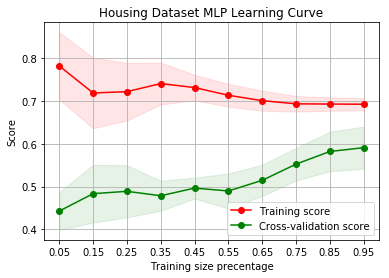


~~~~~~
Execution time metrics
Training time input dim of (46452, 19) : 29.9432 (+/- 15.1464)
Testing time input dim of (11613, 19): 0.0912 (+/- 0.0100)

~~~~~~
10 Fold Cross Validation Accuracy: 0.6666 (+/- 0.0145)
Training Accuracy: 0.6841686041505209
Training F1: 0.684627596413617
Testing Accuracy: 0.6664944458796177
Testing F1: 0.6671611114762955
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


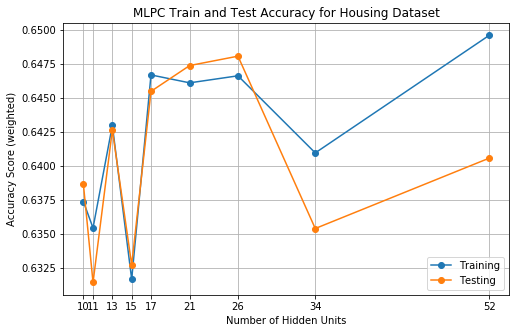


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



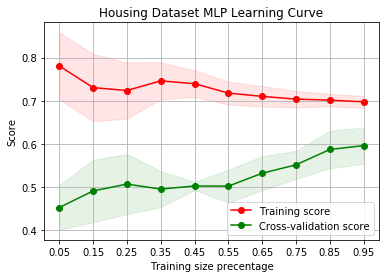


~~~~~~
Execution time metrics
Training time input dim of (46452, 20) : 89.6871 (+/- 79.4009)
Testing time input dim of (11613, 20): 0.1122 (+/- 0.0188)

~~~~~~
10 Fold Cross Validation Accuracy: 0.6709 (+/- 0.0115)
Training Accuracy: 0.6915525703952468
Training F1: 0.6879557142802505
Testing Accuracy: 0.6701971928011711
Testing F1: 0.6667754909408046
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


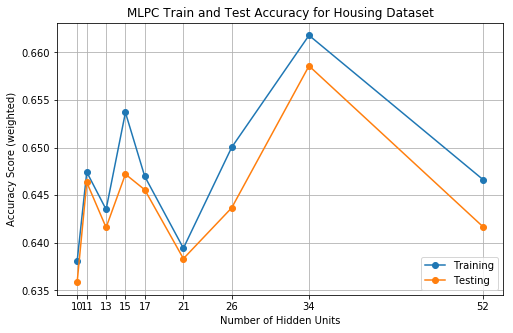


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



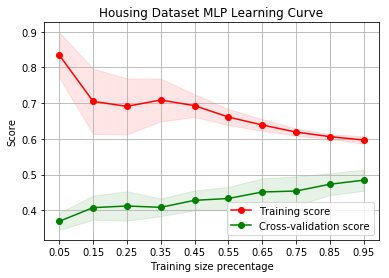


~~~~~~
Execution time metrics
Training time input dim of (46452, 17) : 28.7327 (+/- 1.9713)
Testing time input dim of (11613, 17): 0.1009 (+/- 0.0074)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5577 (+/- 0.0077)
Training Accuracy: 0.5833763885300955
Training F1: 0.5751244556800197
Testing Accuracy: 0.5519676224920348
Testing F1: 0.5441259863677279
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


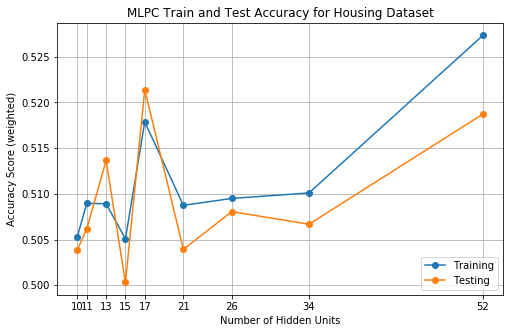


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



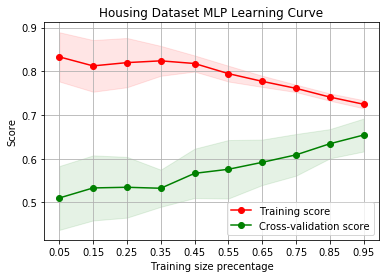


~~~~~~
Execution time metrics
Training time input dim of (46452, 5) : 19.9220 (+/- 1.2065)
Testing time input dim of (11613, 5): 0.0931 (+/- 0.0090)

~~~~~~
10 Fold Cross Validation Accuracy: 0.7093 (+/- 0.0080)
Training Accuracy: 0.7134030827520882
Training F1: 0.7160616818912799
Testing Accuracy: 0.703005252734005
Testing F1: 0.7058033555662351
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


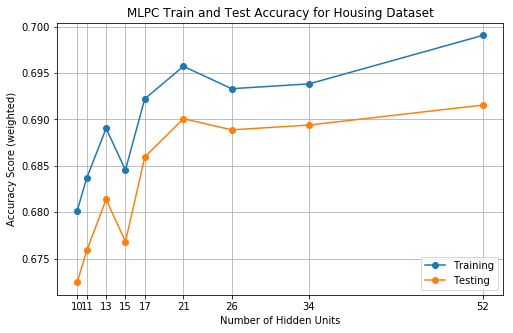


######
Testing Different Activation Functions with 10 Fold X-Val


In [19]:
for d in results:
    analysis = MLPC_Analysis(dataset=d, target='target', save=False)

    # analysis = MLPC_Analysis(dataset=df_main, target='gender', save=False)
    analysis.general_analysis()
    # analysis.max_iteration_analysis()
    analysis.hidden_layer_analysis()
    analysis.activation_analysis()